- PC vs PP

In [1]:
import numpy as np
from scipy.linalg import inv, eigvals, norm
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

from utils import *
from models.tvgti_pc import TimeVaryingSEM as TimeVaryingSEM_PC
from models.tvgti_pp import TimeVaryingSEM as TimeVaryingSEM_PP
from models.tvgti_pc_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PC_NONSPARSE
from models.tvgti_pp_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PP_NONSPARSE

ModuleNotFoundError: No module named 'utils'

In [2]:
def generate_random_S(N, sparsity=0, max_weight=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i + 1, N):
            if np.random.rand() < sparsity:
                weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
                S[j, i] = weight
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)
    
    return S

def modify_S(S, edge_indices, factor=2.0):
    S_modified = S.copy()
    for (i, j) in edge_indices:
        if i != j:
            S_modified[i, j] *= factor
            S_modified[j, i] *= factor
    return S_modified

def generate_stationary_X(N, T, sparsity=0, max_weight=0.5, std_e=np.sqrt(0.5), seed=None):
    S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight, seed=seed)
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X

def generate_piecewise_X(N, T, change_time, change_indices, sparsity=0.2, max_weight=0.5, std_e=np.sqrt(0.5), seed=None):
    pass

def solve_offline_sem(X_up_to_t, lambda_reg):
    N, t = X_up_to_t.shape
    S = cp.Variable((N, N), symmetric=True)
    
    # objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro') + lambda_reg * cp.norm1(S)
    objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro')
    
    constraints = [cp.diag(S) == 0]
    
    prob = cp.Problem(cp.Minimize(objective), constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("CVXPY did not find an optimal solution.")
    
    S_opt = S.value
    return S_opt

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


100%|██████████| 50000/50000 [00:01<00:00, 46643.66it/s]


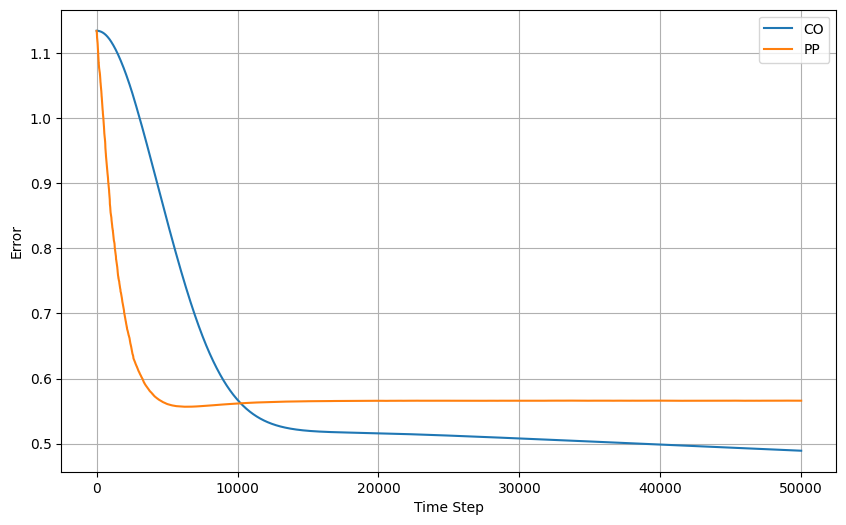

In [12]:
N = 10
T = 50000
sparsity = 100
max_weight = 0.4
change_time = T // 2
variance_e = 0.5
std_e = np.sqrt(variance_e)
seed = None

# TV-SEMシミュレーション
S_series, X = generate_stationary_X(N=N, T=T, sparsity=sparsity, max_weight=max_weight,
                                    std_e=std_e, seed=seed)

# オンラインTV-SEMパラメータ
P = 0
C = 1
lambda_reg = 0
# gamma = 0.999
gamma = 0.9999
alpha = 0.01
beta = 1e-7
beta_pc = 1e-6
beta_pp = 1e-7

tv_sem_pc = TimeVaryingSEM_PC_NONSPARSE(N, lambda_reg, alpha, beta_pc, gamma, P, C)
tv_sem_pp = TimeVaryingSEM_PP_NONSPARSE(N, lambda_reg, alpha, beta_pp, gamma, P, C)
estimates_pc = tv_sem_pc.run(X)
estimates_pp = tv_sem_pp.run(X)

NSE = []
error_opt = []
error_pc = []
error_pp = []

# for i in tqdm(range(T)):
#     S_opt = solve_offline_sem(X[:, :i+1], lambda_reg)
#     error_opt.append(norm(S_opt - S_series[i]))

for i, estimate in enumerate(estimates_pc):
    # S_opt = solve_offline_sem(X[:, :i+1], lambda_reg)
    # NSE.append(norm(estimate - S_opt) / norm(S_opt))
    error_pc.append(norm(estimate - S_series[i]))

for i, estimate in enumerate(estimates_pp):
    error_pp.append(norm(estimate - S_series[i]))

# NSEの時間推移をプロット
plt.figure(figsize=(10,6))
# plt.plot(error_opt, label='OPT')
plt.plot(error_pc, label='CO')
plt.plot(error_pp, label='PP')
plt.xlabel('Time Step')
plt.ylabel('Error')
# plt.title(' between Online TV-SEM and Offline SEM Solutions')
plt.legend()
plt.grid(True)
plt.show()